# Introducción

En la siguiente notebook se presentará la consigna a seguir para el tercer práctico del proyecto, correspondiente a la materia Introducción al Aprendizaje Automático. El objetivo consiste en explorar la aplicación de diferentes métodos de aprendizaje supervisado aprendidos en el curso, a través de experimentos reproducibles, y evaluando a su vez la conveniencia de uno u otro, así como la selección de diferentes hiperparámetros a partir del cálculo de las métricas pertinentes.

En este caso, enfrentamos un problema de clasificación binario de posicionamiento respecto de un tópico. Para este práctico vamos a utilizar únicamente los datos etiquetados, que ya vienen divididos en train y test. Buscamos analizar distintos problemas que puedan surgir como el desbalanceo de clases


## Organización

El trabajo va a estar organizado en dos grandes secciones: preprocesamiento y aplicación de los clasificadores.

#### Preprocesamiento
En la parte de preprocesamiento lo que vamos a hacer va a ser:

1 - Obtener el dataset

2 - Tokenizar

3 - Aplicar alguna curación

4 - Balanceo de clases

5 - Representar el texto como vector: CountVectorizer

6 - Optativo: se puede representar el texto de otras maneras? Embeddings!

#### Clasificadores

1 - Perceptron

2 - K-NN

3 - Regresión Logística

4 - Evaluación de los clasificadores

5 - Optimización de Hiperparámetros

Esto para los tres datasets CON y SIN balanceo de clases


In [1]:
import pandas as pd
from nltk.tokenize import TweetTokenizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.metrics import accuracy_score, f1_score, make_scorer, classification_report
from sklearn.model_selection import GridSearchCV

In [2]:
pd.set_option('display.max_rows', 10)
import warnings
warnings.filterwarnings("ignore")

In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
pd.set_option('display.max_rows', 20000)
pd.set_option('display.max_columns', 20000)
pd.set_option('display.max_colwidth', -1)

# Preprocesamiento

### Cargamos los datos

In [4]:
train = pd.read_csv("train.csv", sep=',', encoding="latin1").fillna(method="ffill")
test = pd.read_csv("test.csv", sep=',', encoding="latin1").fillna(method="ffill")

In [5]:
abortion_train = train[train["Target"] == "Legalization of Abortion"]
abortion_test = test[test["Target"] == "Legalization of Abortion"]

In [6]:
print(abortion_train.shape[0])
print(abortion_test.shape[0])

653
280


Sólo vamos a usar el tweet y el stance. Como encima ya tenemos dividido el corpus según el target, vamos a eliminar todas las columnas excepto tweet y stance

In [7]:
abortion_train.drop(columns = ["Target", "Opinion Towards", "Sentiment"], inplace=True)
abortion_test.drop(columns = ["Target", "Opinion Towards", "Sentiment"], inplace=True)

### Tokenizamos

En principio como mínimo para realizar algún tipo de preprocesamiento y luego transformar nuestros datos en algo que pueda ser tomado como input por los clasificadores que vamos a probar necesitamos dividir nuestro tweet en formato string en una lista de palabras. La división requiere tomar decisiones sobre cómo tratar anomalías. En especial en twitter donde abundan las abreviaciones, errores ortográficos, puntuaciones raras, emojis, lo que se le ocurra al usuario.

Hay muchas formas distintas de tokenizar y hay clasificadores que vienen con tokenizadores especiales incorporados al punto tal de que no pueden funcionar con otra tokenización (fastText y BERT por ejemplo separan la raíz de las parabras de sus prefijos y sufijos para poder relacionar palabras similares, como asociar todas las conjugaciones de un verbo a una misma raíz).

Nosotros vamos a usar uno bien simple que tiene pocas funciones pero tiene algunas funciones pensadas especialmente para redes sociales, como por ejemplo detectar emojis o separar una palabra de sus signos de puntuación o asociar muchos signos de puntuación iguales y seguidos como si fueran uno solo (por ejemplo, !!!!!).

https://www.nltk.org/api/nltk.tokenize.html

Hay tres parámetros que pueden explorar leyendo la documentación (los que están escritos). Prueben ver qué pasa cuando cambian cada uno

In [8]:
tokenizer = TweetTokenizer(preserve_case=False, reduce_len=False, strip_handles=True)

- preserve_case = False ---> pasa a minúscula
- reduce_len = False ---> detecta cuando un carácter está repetido más de tres veces y lo corta en a lo sumo 3 repeticiones
- strip_handles = True ---> elimina las palabras que comienzan con @

In [9]:
# Ejemplo
print('Tweet: '+ abortion_train["Tweet"].iloc[1])
print('Tweet tokenizado: ') 
tokenizer.tokenize(abortion_train["Tweet"].iloc[1])

Tweet: @tooprettyclub Are you OK with #GOP males telling you what you can and can't do with your own body?
Tweet tokenizado: 


['are',
 'you',
 'ok',
 'with',
 '#gop',
 'males',
 'telling',
 'you',
 'what',
 'you',
 'can',
 'and',
 "can't",
 'do',
 'with',
 'your',
 'own',
 'body',
 '?']

### Preprocesamiento

El preprocesamiento para twitter requiere tomar varias decisiones. Recomiendo que vean un poco el dataset y piensen con qué palabras quieren trabajar y cuales quieren remover. Les dejo el esqueleto de una función de preprocesamiento que sólo tokeniza pero que puede tomar dos parámetros optativos para remover hashtags y números.

#### Ejercicio 1

Agregarle a la función de preprocesamiento que borre las urls (palabras que empiecen con http). Agregarle código para que agregue o saque texto de acuerdo con al menos un criterio propuesto por ustedes (menciones a los usuarios, caritas/emojis, puntuación).

In [11]:
#import emoji
import string
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Manuela\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [12]:
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [13]:
stop_words = set(stopwords.words('english')) 

In [38]:
def preprocesar(text, remove_hashtags=True, remove_numbers=True, remove_http=True, remove_punctuation=True, remove_stopwords=True):
    toks = tokenizer.tokenize(text) # Arma lista de palabras
    ret = []
    for tok in toks:
        if tok[0] == "#" and remove_hashtags:  # Removemos hashtag si remove_hashtags = True
            continue    
        if tok.isnumeric() and remove_numbers:   # Removemos los números si remove_numbers = True
            continue 
        if tok[:4] == "https" and remove_http:  # Removemos los url si remove_http = True
            continue  
        if tok in string.punctuation and remove_punctuation: # Removemos !"#$%&'()*+, -./:;<=>?@[\]^_`{|}~ si remove_punctuation=True
            continue 
        if tok in stop_words and remove_stopwords:  # Removemos los stopwords si remove_stopwords = True
            continue   
        ret.append(tok) 
    return " ".join(ret)

In [39]:
# Ejemplo
w = '@donald are you in the wordl??? #genial;'

preprocesar(w, remove_hashtags = True,
               remove_numbers=True, 
               remove_http=True, 
               remove_punctuation=True,
               remove_stopwords=True)

'wordl'

Falta eliminar los emoji:
- https://towardsdatascience.com/a-beginners-guide-to-preprocessing-text-data-using-nlp-tools-5cb52a8d3cd

In [40]:
# Hacer esto para todos los datasets, train y test de los 3 tópicos
abortion_train["Tweet_procesado"] = abortion_train["Tweet"].apply(lambda x: preprocesar(x))
abortion_test["Tweet_procesado"] = abortion_test["Tweet"].apply(lambda x: preprocesar(x))

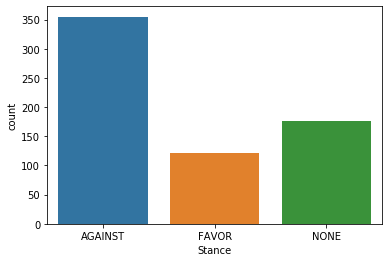

In [41]:
import seaborn as sns
sns.countplot(abortion_train.Stance)

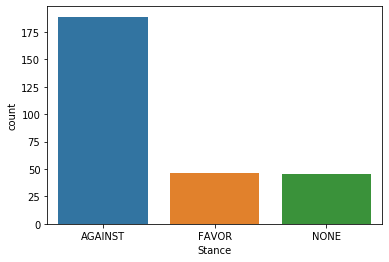

In [42]:
sns.countplot(abortion_test.Stance)

### Balanceo de clases

En el práctico anterior ya analizaron la distribución de las clases según cada target (tópico) del dataset. Queremos explorar la posibilidad de hacer un balanceo de clases. Para eso, analizamos tópico por tópico si esto es posible y las dificultades que tiene.

Para el dataset de feminismo, tenemos dos versiones de train, una con correcciones y otra sin. En la versión con correcciones cambia el balanceo de las clases a algo más equitativo que en su version original. Por este motivo, vamos a descartar hacer un balanceo de clases en este dataset.  ## dónde está la segunda versión???

Para el dataset de cambio climático tenemos un desbalanceo tan grande que, por ejemplo, sólo tenemos 11 ejemplos de la clase Against (el 6,5% del corpus). El problema que tiene una distribución tan desigual es que resulta dificil aplicar técnicas como el subsampling porque nos quedaríamos con 33 tweets de entrenamiento, o el oversampling porque para que las clases queden parejas, deberíamos repetir un mismo tweet muchas veces.

Por lo tanto, nos queda el corpus de aborto:

#### Ejercicio 2

Hacer subsampling del corpus de aborto y guardarlo como un nuevo dataset. A partir de ahora, todos los experimentos que corran deberán correrlos además de para los tres corpus respectivos a cada tópico, también para este nuevo corpus de aborto con sus clases balanceadas. Luego vamos a comparar los resultados obtenidos con y sin balanceo de clases

In [43]:
df1 = abortion_train[abortion_train.Stance == 'AGAINST'].sample(n=175, random_state=1)
df2 = abortion_train[(abortion_train.Stance == 'FAVOR') | (abortion_train.Stance == 'NONE')]

In [44]:
print(df1.shape)
print(df2.shape)

(175, 3)
(298, 3)


In [45]:
abortion_train_balanced = pd.concat([df1,df2])

In [46]:
abortion_train_balanced.shape

(473, 3)

In [47]:
abortion_test.shape[0]

280

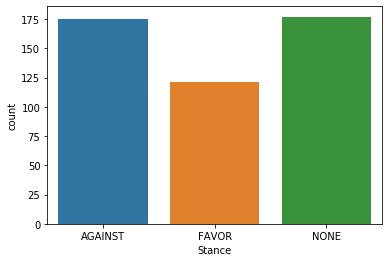

In [48]:
sns.countplot(abortion_train_balanced.Stance)

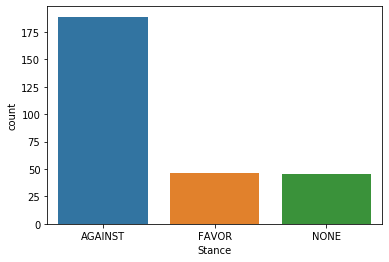

In [49]:
sns.countplot(abortion_test.Stance)

In [50]:
abortion_train_balanced["Tweet_procesado"] = abortion_train_balanced["Tweet"].apply(lambda x: preprocesar(x))
abortion_test["Tweet_procesado"] = abortion_test["Tweet"].apply(lambda x: preprocesar(x))

### Representación como vector

Los algoritmos de Machine Learning trabajan con espacios vectoriales. Entonces siempre que trabajemos con Procesamiento de Lenguaje Natural, como es nuestro caso, se plantea la cuestión de cómo representar texto con números. Hay muchas maneras de hacer esto y es un campo que sigue evolucionando con el tiempo. Una opción muy básica es asignarle a cada palabra que aparece en nuestro dataset un número según el orden en el que aparecen. Luego, una oración es un vector de índices de esas palabras. Pero el problema que tiene esto es que los algoritmos de Machine Learning también requieren que los vectores tengan una longitud fija, con lo cual hay que recortar la oración o agregarle ceros al final. Por eso un enfoque clásico para representar texto es el Bag Of Words: un vector de bits del tamaño de todo nuestro vocabulario que tiene un uno si la palabra está en la oración y un 0 si no está.

- https://es.wikipedia.org/wiki/Modelo_bolsa_de_palabras
- https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction

En particular, vamos a usar la libreria CountVectorizer que implementa el Bag Of Words de manera esparsa (eficiente) y le agrega varios features que van a sernos muy útiles:

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

En particular, vamos a usar los parámetros min_df y max_df que se corresponden con min y max document frequency. Ámbos toman valores entre 0 y 1 y estipulan el rango de frecuencia de aparición de una palabra dentro de un documento que vamos a aceptar. Es decir, si min_df es 0.005, todas las palabras que representen menos de un 0,5% de las palabras totales serán descartadas. Por el otro lado, si max_df es 0.35, todas las palabras que representen más de un 35% del total de palabras serán descartadas. Nos interesa descartar las palabras con demasiada frecuencia porque probablemente no tengan valor en términos de la entropía que aportan (es decir, no aportan información: pueden ser conectores, artículos, etc.) y las que tienen muy poca frecuencia porque pueden ser outliers, palabras demasiado específicas que no aportan a la tarea que queremos desarrollar.

Las Bag Of Words, sin embargo, tienen un problema importante: no preservan el contexto y la relación semántica de las palabras entre sí. Este problema dio lugar a otros enfoques como los embeddings sobre los cuales les voy a dejar algunas cosas para que lean al final de manera optativa por si les da curiosidad. Incluso, luego de los embeddings, surgieron recientemente los contextualized embeddings que además de considerar la relación semántica, consideran el orden puntual dentro de la oración.

Pero volviendo a las Bag Of Words, se puede hacer un pequeño "truco" para tener en cuenta, al menos parcialmente, algunas frases o expresiones con el orden en el que aparecen: el parámetro ngram_range calcula la frecuencia de ngramas. Resulta muy útil para descubrir frases o expresiones comunes (además de las palabras comunes). Además, en combinación con el parámetro "analyzer" se pueden usar como ngramas de palabras o de caracteres.

#### Ejercicio 3

Explorar los hiperparámetros de CountVectorizer. Ir modificando los valores de min_df, max_df y ngram-range. Observar cómo cambia el tamaño del vector.

NOTA: Como el tamaño del vector (es decir, el vocabulario) debe ser igual para el entrenamiento como para el test, tenemos que vectorizar al mismo tiempo el dataset de train y de test

In [51]:
text_train_abortion_balanced = abortion_train_balanced["Tweet_procesado"]
text_test_abortion = abortion_test["Tweet_procesado"]

vectorizer = CountVectorizer(
    binary=True, min_df=0.0075, max_df=0.75, ngram_range=(1, 10),
    #stop_words=stopwords.words('spanish')
)

X_abortion_balanced = vectorizer.fit_transform([*text_train_abortion_balanced, *text_test_abortion])

In [52]:
VEC_train_abortion_balanced = X_abortion_balanced[:len(text_train_abortion_balanced)]
VEC_test_abortion = X_abortion_balanced[len(text_train_abortion_balanced):]

In [53]:
print(X_abortion_balanced.shape)
print(vectorizer.vocabulary_)

(753, 186)
{'pregnancy': 121, 'time': 159, 'without': 175, 'can': 26, 'force': 53, 'someone': 140, 'mean': 101, 'many': 97, 'hope': 70, 'choose': 32, 'life': 85, 'rt': 134, 'unborn': 162, 'children': 30, 'rights': 133, 'world': 181, 'law': 81, 'god': 61, 'men': 103, 'think': 158, 'women': 178, 'yes': 185, 'right': 132, 'get': 57, 'little': 87, 'ones': 115, 'even': 47, 'nothing': 113, 'medical': 102, 'care': 27, 'support': 144, 'human': 71, 'lives': 89, 'alive': 2, 'conception': 34, 'abortion': 0, 'issue': 75, 'that': 152, 'like': 86, 'work': 180, 'day': 37, 'love': 92, 'wrong': 183, 'mother': 105, 'texas': 149, 'anti': 8, 'call': 25, 'babies': 13, 'responsible': 131, 'enough': 44, 'take': 146, 'baby': 14, 'sex': 139, 'something': 141, 'must': 108, 'dead': 39, 'know': 80, 'womb': 177, 'human life': 72, 'new': 112, 'thank': 150, 'another': 7, 'equal': 45, 'freedom': 54, 'stop': 143, 'killing': 79, 'say': 137, 'choice': 31, 'legal': 83, 'way': 168, 'pro': 124, 'away': 12, 'pro life': 126,

### EXTRA: Word Embeddings

Los embeddings de palabras son algo bastante nuevo en el campo del Procesamiento Del Lenguaje Natural (ultimos 10 años) pero fueron algo totalmente revolucionario que cambio absolutamente la disciplina. Desde que aparecieron las primeras versiones de embeddings (word2vec, glove, varias otras) surgieron muchas versiones distintas hechas con diversos algoritmos y técnicas. Pero todos tienen algo en común: tratan de captar la semántica de una palabra representandola con un vector (un número) que se calcula en base a los valores de las palabras que aparecen en el contexto de esa palabra. O sea, para cada palabra se calcula de manera iterativa un valor sobre la base de qué palabras aparecen antes y después en miles y miles de textos que se usan para entrenar los embeddings. Esos valores luego se exportan y se usan como representación de las palabras.

No es del alcance de este trabajo práctico meterse en este tema, que correspondería más a un curso introductorio de Procesamiento del Lenguaje Natural y ya no a Machine Learning, pero me pareció interesante comentarselos como una alternativa (muy muy) frecuente frente al problema de decidir como representar texto con números.

Si les interesa y quieren leer/investigar más al respecto, aca hay una clase del curso de PLN de Standford:
https://www.youtube.com/watch?v=ERibwqs9p38&list=PL3FW7Lu3i5Jsnh1rnUwq_TcylNr7EkRe6&index=2

La clase está buena aunque tiene bastante matemática. Es más que nada para que se entienda el concepto igualmente

# Clasificadores

A continuación van a realizar experimentos con tres clasificadores básicos. Para cada uno van a tener que probar una serie de hiperparámetros. Les incluyo la documentación para que puedan leer qué es cada hiperparámetro que están probando. Luego de cada corrida, evaluan el clasificador con cuatro métricas: Accuracy Score, F1 micro, F1 macro y el promedio del F1 de la clase Favor con el F1 de la clase Against. La idea es que vayan cambiando los valores de un hiperparámetro dejando fijos el resto y vean cómo ese cambio impacta en las métricas. Finalmente, para cada clasificador escriban un pequeño informe planteando cuan sensible es cada parámetro respecto de cada métrica, por qué piensan que es así de sensible y cuales son los mejores valores que encontraron. Finalmente, elijan el clasificador que les parezca más adecuado para esta tarea y justifiquen su elección. Para ese clasificador que hayan elegido van a probar luego, una busqueda más exhaustiva de hiperparámetros usando Grid Search. Este procedimiento deben hacerlo **al menos** para **dos de los cuatro** datasets con los que venimos trabajando (aborto, aborto balanceado, cambio climático y feminismo)

### Perceptron

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Perceptron.html

In [30]:
y_train = abortion_train_balanced["Stance"]
y_test = abortion_test["Stance"]

# En principio, pueden utilizar el módulo que sigue, con los parámetros por defecto y los que definan a continuación:
penalty = 'l2' # No cambia con las otras opciones (None, l2, y elasticnet)
alpha = 0.001   # A medida que aumenta es test da mejor que el train si penalty es l1 o l2, con none no es sensible
                # A medida que disminuye overfittea si penalty es l1 o l2, con none no es sensible
max_iter = 100  # No cambia con None ni con l2 pero con l1 mientras menos iteraciones menos overfiteo
tol = 0.1  # Mientras más chico más overfiteo con el l2 

model = Perceptron(penalty = penalty, alpha = alpha, fit_intercept=True, max_iter = max_iter, tol = tol, shuffle=True, random_state=0, class_weight=None, warm_start=False)
model.fit(VEC_train_abortion_balanced, y_train)

Perceptron(alpha=0.001, class_weight=None, early_stopping=False, eta0=1.0,
           fit_intercept=True, max_iter=100, n_iter_no_change=5, n_jobs=None,
           penalty='l2', random_state=0, shuffle=True, tol=0.1,
           validation_fraction=0.1, verbose=0, warm_start=False)

In [31]:
y_pred_train =  model.predict(VEC_train_abortion_balanced)
accuracy_train = accuracy_score(y_train, y_pred_train)
f1_train_micro = f1_score(y_train, y_pred_train, average="micro", labels=["NONE", "AGAINST", "FAVOR"])
f1_train_macro = f1_score(y_train, y_pred_train, average="macro", labels=["NONE", "AGAINST", "FAVOR"])
f1_train = f1_score(y_train, y_pred_train, average=None, labels=["NONE", "AGAINST", "FAVOR"])
f1_train_average = (f1_score(y_train, y_pred_train, average=None, labels=["AGAINST"]) + f1_score(y_train, y_pred_train, average=None, labels= ["FAVOR"]))/2

print("Accuracy para conjunto de entrenamiento: %.2f" % accuracy_train)
print("F1 micro para conjunto de entrenamiento: %.2f" % f1_train_micro)
print("F1 macro para conjunto de entrenamiento: %.2f" % f1_train_macro)
print("F1 average para conjunto de entrenamiento: %.2f" % f1_train_average)

y_pred_test =  model.predict(VEC_test_abortion)
accuracy_test = accuracy_score(y_test, y_pred_test)
f1_test_micro = f1_score(y_test, y_pred_test, average="micro", labels=["NONE", "AGAINST", "FAVOR"])
f1_test_macro = f1_score(y_test, y_pred_test, average="macro", labels=["NONE", "AGAINST", "FAVOR"])
f1_test = f1_score(y_test, y_pred_test, average=None, labels=["NONE", "AGAINST", "FAVOR"])
f1_test_average = (f1_score(y_test, y_pred_test, average=None, labels=["AGAINST"]) + f1_score(y_test, y_pred_test, average=None, labels= ["FAVOR"]))/2

print("Accuracy para conjunto de test: %.2f" % accuracy_test)
print("F1 micro para conjunto de test: %.2f" % f1_test_micro)
print("F1 macro para conjunto de test: %.2f" % f1_test_macro)
print("F1 average para conjunto de test: %.2f" % f1_test_average)

Accuracy para conjunto de entrenamiento: 0.71
F1 micro para conjunto de entrenamiento: 0.71
F1 macro para conjunto de entrenamiento: 0.70
F1 average para conjunto de entrenamiento: 0.69
Accuracy para conjunto de test: 0.54
F1 micro para conjunto de test: 0.54
F1 macro para conjunto de test: 0.51
F1 average para conjunto de test: 0.54


### K-NN

https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

In [32]:
from sklearn.neighbors import KNeighborsClassifier

In [55]:
n_neighbors = 3 # Cantidad de vecinos a tener en cuenta
                # A medida que disminuye overfittea y a medida que aumenta los scores empeoran
metric = 'cosine'     # Medida de distancia. Algunas opciones: cosine, euclidean, manhattan.

model = KNeighborsClassifier(n_neighbors=n_neighbors, metric=metric)
model.fit(VEC_train_abortion_balanced, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='cosine',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [34]:
y_pred_train =  model.predict(VEC_train_abortion_balanced)
accuracy_train = accuracy_score(y_train, y_pred_train)
f1_train_micro = f1_score(y_train, y_pred_train, average="micro", labels=["NONE", "AGAINST", "FAVOR"])
f1_train_macro = f1_score(y_train, y_pred_train, average="macro", labels=["NONE", "AGAINST", "FAVOR"])
f1_train = f1_score(y_train, y_pred_train, average=None, labels=["NONE", "AGAINST", "FAVOR"])
f1_train_average = f1_train_average = (f1_score(y_train, y_pred_train, average=None, labels=["AGAINST"]) + f1_score(y_train, y_pred_train, average=None, labels= ["FAVOR"]))/2

print("Accuracy para conjunto de entrenamiento: %.2f" % accuracy_train)
print("F1 micro para conjunto de entrenamiento: %.2f" % f1_train_micro)
print("F1 macro para conjunto de entrenamiento: %.2f" % f1_train_macro)
print("F1 average para conjunto de entrenamiento: %.2f" % f1_train_average)

y_pred_test =  model.predict(VEC_test_abortion)
accuracy_test = accuracy_score(y_test, y_pred_test)
f1_test_micro = f1_score(y_test, y_pred_test, average="micro", labels=["NONE", "AGAINST", "FAVOR"])
f1_test_macro = f1_score(y_test, y_pred_test, average="macro", labels=["NONE", "AGAINST", "FAVOR"])
f1_test = f1_score(y_test, y_pred_test, average=None, labels=["NONE", "AGAINST", "FAVOR"])
f1_test_average = (f1_score(y_test, y_pred_test, average=None, labels=["AGAINST"]) + f1_score(y_test, y_pred_test, average=None, labels= ["FAVOR"]))/2

print("Accuracy para conjunto de test: %.2f" % accuracy_test)
print("F1 micro para conjunto de test: %.2f" % f1_test_micro)
print("F1 macro para conjunto de test: %.2f" % f1_test_macro)
print("F1 average para conjunto de test: %.2f" % f1_test_average)

Accuracy para conjunto de entrenamiento: 0.72
F1 micro para conjunto de entrenamiento: 0.72
F1 macro para conjunto de entrenamiento: 0.72
F1 average para conjunto de entrenamiento: 0.72
Accuracy para conjunto de test: 0.61
F1 micro para conjunto de test: 0.61
F1 macro para conjunto de test: 0.50
F1 average para conjunto de test: 0.60


### Logistic Regression

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [35]:
penalty =  'l2' # Tipo de regularización: l1 (valor absoluto), l2 (cuadrados).
                  # Con none overfitea, l1 y elasticnet no los soporta
alpha =  10 # Parámetro de regularización. También denominado como parámetro `lambda`. Debe ser mayor que 0.
            # A medida que disminuye overfitea y a medida que aumenta empeora
max_iter =  10 # Cantidad máxima de iteraciones del algoritmo.
               # No es sensible para valores muy altos y para valores bajos empeora
tol =  0.0001 # Precisión del algoritmo (error mínimo entre una iteración y la siguiente).
        # Para valores chicos no es sensible y para valores altos empeora
model = LogisticRegression(penalty=penalty, C=1./alpha, max_iter=max_iter, tol=tol)
model.fit(VEC_train_abortion_balanced, y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [36]:
y_pred_train =  model.predict(VEC_train_abortion_balanced)
accuracy_train = accuracy_score(y_train, y_pred_train)
f1_train_micro = f1_score(y_train, y_pred_train, average="micro", labels=["NONE", "AGAINST", "FAVOR"])
f1_train_macro = f1_score(y_train, y_pred_train, average="macro", labels=["NONE", "AGAINST", "FAVOR"])
f1_train = f1_score(y_train, y_pred_train, average=None, labels=["NONE", "AGAINST", "FAVOR"])
f1_train_average = f1_train_average = (f1_score(y_train, y_pred_train, average=None, labels=["AGAINST"]) + f1_score(y_train, y_pred_train, average=None, labels= ["FAVOR"]))/2

print("Accuracy para conjunto de entrenamiento: %.2f" % accuracy_train)
print("F1 micro para conjunto de entrenamiento: %.2f" % f1_train_micro)
print("F1 macro para conjunto de entrenamiento: %.2f" % f1_train_macro)
print("F1 average para conjunto de entrenamiento: %.2f" % f1_train_average)

y_pred_test =  model.predict(VEC_test_abortion)
accuracy_test = accuracy_score(y_test, y_pred_test)
f1_test_micro = f1_score(y_test, y_pred_test, average="micro", labels=["NONE", "AGAINST", "FAVOR"])
f1_test_macro = f1_score(y_test, y_pred_test, average="macro", labels=["NONE", "AGAINST", "FAVOR"])
f1_test = f1_score(y_test, y_pred_test, average=None, labels=["NONE", "AGAINST", "FAVOR"])
f1_test_average = (f1_score(y_test, y_pred_test, average=None, labels=["AGAINST"]) + f1_score(y_test, y_pred_test, average=None, labels= ["FAVOR"]))/2

print("Accuracy para conjunto de test: %.2f" % accuracy_test)
print("F1 micro para conjunto de test: %.2f" % f1_test_micro)
print("F1 macro para conjunto de test: %.2f" % f1_test_macro)
print("F1 average para conjunto de test: %.2f" % f1_test_average)

Accuracy para conjunto de entrenamiento: 0.74
F1 micro para conjunto de entrenamiento: 0.74
F1 macro para conjunto de entrenamiento: 0.73
F1 average para conjunto de entrenamiento: 0.69
Accuracy para conjunto de test: 0.53
F1 micro para conjunto de test: 0.53
F1 macro para conjunto de test: 0.52
F1 average para conjunto de test: 0.56


### Grid Search

El algoritmo que obtuve mejores métricas es el de los vecinos más cercanos

In [37]:
# Para la búsqueda de los mejores parámetros, por ejemplo de logistic regression, pueden usar:

exploring_params = {
        'n_neighbors': [ 1, 2, 3, 4, 5, 10, 20, 100, 200], # Inversa del coeficiente de regularización
        'metric': ['cosine', 'manhattan', 'euclidean', 'minkowvski'],  # Cantidad de iteraciones
    }

m = KNeighborsClassifier()
n_cross_val =  6 # Seleccionar folds
scoring = "f1_micro"
model = GridSearchCV(m, exploring_params, cv=n_cross_val, scoring=scoring)
    
model.fit(VEC_train_abortion_balanced, y_train)

print("Mejor conjunto de parámetros:")
print(model.best_params_, end="\n\n")
print()
print("Puntajes de la grilla:", end="\n\n")
means = model.cv_results_['mean_test_score']
stds = model.cv_results_['std_test_score']
print()
print("Reporte de clasificación para el mejor clasificador (sobre conjunto de evaluación):", end="\n\n")
y_true, y_pred = y_test, model.predict(VEC_test_abortion)
print(classification_report(y_true, y_pred), end="\n\n")

print("================================================", end="\n\n")

GridSearchCV(cv=6, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'metric': ['cosine', 'manhattan', 'euclidean',
                                    'minkowvski'],
                         'n_neighbors': [1, 2, 3, 4, 5, 10, 20, 100, 200]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1_micro', verbose=0)

Mejor conjunto de parámetros:
{'metric': 'cosine', 'n_neighbors': 20}


Puntajes de la grilla:


Reporte de clasificación para el mejor clasificador (sobre conjunto de evaluación):

              precision    recall  f1-score   support

     AGAINST       0.86      0.50      0.64       189
       FAVOR       0.36      0.59      0.44        46
        NONE       0.31      0.64      0.42        45

    accuracy                           0.54       280
   macro avg       0.51      0.58      0.50       280
weighted avg       0.69      0.54      0.57       280





Agregar matriz de confusión